# Welcome to the QTIM DCE Processing Notebook!

Our goal is to show you how you can use qtim_tools' DCE processing module to process your data, and discuss some of the methods we use to do our processing. This first section will be a usage tutorial based on the QIBA tofts phantom data located at  https://sites.duke.edu/dblab/qibacontent/.

## Usage Tutorial

The qtim_tools library is a python package with many submodules, each devoted to a particular area of interest at the Quantiative Tumor Imaging Lab at the Martinos Center (MGH/HST). You can install the latest version of qtim_tools with the Python package manager pip, using the command "pip install qtim_tools". You can also clone this GitHub repository and run the command "python setup.py install" from the repository's base directory.

We'll start by loading some test data. Our first test case will use a digitally-created DCE-MRI phantom. This phantom, courtesy of the Quantitative Imaging Biomarkers Alliance (QIBA) is meant to simulate a range of combinations of ktrans and ve values with a high level of noise. The input data looks like similar to the images below. A ticker keeps track of timepoint in seconds in the upper-left-hand corner, and an area from which to extract an arterial input function is located in the bottom 10 rows. You can find more information about the QIBA_tofts_v9 phantom at this page: https://sites.duke.edu/dblab/qibacontent/.

![QIBA Phantom Input](QIBA_Phantom_Input.PNG)

The resulting ktrans and ve maps should look similar to the maps below, assuming there had been no noise.

![QIBA Phantom Expected Results](QIBA_Phantom_Expected_Results.png)

As of now, the qtim_dce library is only configured to work with Nifti files. If you have a 4D (or 3D) DCE-MRI Nifti file on-hand, you can replace the variable test_file below with your own filepath. Otherwise, you can use qtim_tools data iporter to load this particular test case.


In [1]:
from qtim_tools.test_data import load_test_file

# test_file = "your_file_here.nii.gz"
test_file = load_test_file(data="dce_tofts_v9")
print 'Test File Loaded: ' + test_file

Test File Loaded: c:\users\abeers\documents\github\public_qtim\qtim_tools\qtim_tools\test_data\test_data_dce\tofts_v9.nii.gz


The submodule most important to us in this tutorial is the "qtim_dce" submodule. For now, there is only one important submodule in qtim_dce. This is the tofts_parametric_mapper submodule, which use the Tofts-Kermode model to create ktrans, ve, and area-under-the-curve maps for a give 3D or 4D temporal image. We can import it using the piece of code below.

In [2]:
from qtim_tools.qtim_dce import tofts_parametric_mapper

DCE parametric maps -- especially those calculated by the Tofts model -- are very sensitive to input parameters such as TR (Recovery Time), TE (Echo Time), assumed T1 measurements in normal tissue, relaxivity of the provided contrast agent, and especially the provided arterial input function (AIF). The tofts_parametric_mapper function lets you specify all of these values in the parameters below.

Much of this data will be contained in DICOM headers for your own data, if available. Below are input parameters suited to the breast test data loaded above.


In [3]:
# Input Parameters
T1_tissue=1000
T1_blood=1440
relaxivity=.0045
TR=5
TE=2.1 
scan_time_seconds=(6*60) 
hematocrit=0.45
injection_start_time_seconds=60 
flip_angle_degrees=30

You may also want to input a label file that specifies a particular region of interest to calculate your parametric map in. Map calculation can be time-consuming in Python, especially without pre-specified parallel processing, and so localizing your calculation to pre-defind region of interest may make your processing go faster.


In [4]:
test_file_label = load_test_file(data="dce_tofts_v9_label")
print 'Loaded test label: ' + test_file_label

# Label File Parameters
label_file=test_file_label

Loaded test label: c:\users\abeers\documents\github\public_qtim\qtim_tools\qtim_tools\test_data\test_data_dce\tofts_v9-label.nii.gz


We provide support for extracting average arterial input functions from registered nifti label files. We also provide support for loading loading arterial input functions from text files, with sequential intensity values interrupted by semi-colons (";"). Finally we provide support for generating a population-level AIF based on the Parker model (citation). Adjust the parameters below for your specific case, or use the AIF label that we provide for the phantom data.

In [5]:
test_file_AIF = load_test_file(data="dce_tofts_v9_aif")
print 'Loaded test AIF: ' + test_file_AIF

# AIF Parameters
AIF_label_file=test_file_AIF
AIF_text_file=[]
AIF_mode="label" # options: population, label, textfile

Loaded test AIF: c:\users\abeers\documents\github\public_qtim\qtim_tools\qtim_tools\test_data\test_data_dce\tofts_v9-AIF-label.nii.gz


If you want to provide a T1 map for your data, change the T1_map_file parameter below to your filepath. This will overwrite the provided options for T1_tissue and T1_blood in the previous steps. Our example data will not use a T1 map, so we leave this parameter blank.

In [6]:
# T1 Map Parameters
T1_map_file=[]

Finally, you should specify how many CPU processors you want your machine to use. Currently, Windows 10 seems to have issues with our particular method of parallelization; in that case, you can disable parallel processing by settting processors to 1.

You should also set an output prefix to where you want to save your file. Output files will take the form "[prefix]ktrans.nii.gz", "[prefix]ve.nii.gz", and "[prefix]auc.nii.gz"

In [7]:
# Output and Processing Parameters.
processes = 1;
output_filepath_prefix = "./Example_tofts_v9_"

Finally, run the tofts_parametric_mapper command with all of the variables we've pre-defined. You should see output with constant updates as the function works through your provided file.

In [8]:
tofts_parametric_mapper.execute(input_filepath=test_file,
T1_tissue=T1_tissue,
T1_blood=T1_blood,
relaxivity=relaxivity,
TR=TR, 
TE=TE, 
scan_time_seconds=scan_time_seconds, 
hematocrit=hematocrit, 
injection_start_time_seconds=injection_start_time_seconds, 
flip_angle_degrees=flip_angle_degrees, 
label_file=test_file_label,
T1_map_file=T1_map_file,
AIF_label_file=AIF_label_file,
AIF_text_file=AIF_text_file,
AIF_mode=AIF_mode,
outfile_prefix=output_filepath_prefix, 
processes=processes)

AttributeError: 'module' object has no attribute 'execute'

Let's check out the results to see if they matched what we expected. We're going to use the qtim_utilities submodule to quickly load nifti files into numpy arrays, and check them out using matplotlib. If you are interested in manipulating nifti arrays in python, you should also turn to the python package nibabel (http://nipy.org/nibabel/).

We'll first import the results using nifti_2_numpy.

In [9]:
from qtim_tools.qtim_utilities.nifti_util import nifti_2_numpy

ktrans_array_data = nifti_2_numpy(output_filepath_prefix + 'ktrans.nii.gz')
ve_array_data = nifti_2_numpy(output_filepath_prefix + 've.nii.gz')
auc_array_data = nifti_2_numpy(output_filepath_prefix + 'auc.nii.gz')

We'll then visualize it using matplotlib.

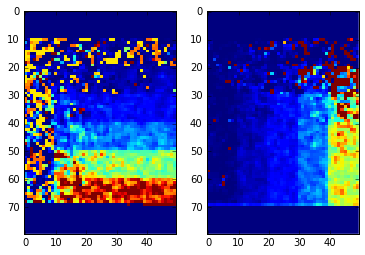

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(ktrans_array_data.T, interpolation='none', aspect='auto', vmin=0, vmax=.5)
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(ve_array_data.T, interpolation='none', aspect='auto', vmin=0, vmax=1)
plt.show()

Not bad! While qtim_tools achieve perfect accuracy on noiseless phantom data, some variation can be expected in noisy data -- especially at low ktrans and high ve values. qtim_tools has recently had the best performance across a multi-institution competition on noisy DCE data, but difficult-to-fit data will remain. Apply your own pre-processing methods as necessary, and make sure you have correctly set all of the required DCE parameters.